# Convolutional Neural Network

Notebook inspired by https://github.com/aymericdamien/TensorFlow-Examples/
and by https://github.com/pkmital/CADL.

Example is using the [MNIST database of handwritten digits](http://yann.lecun.com/exdb/mnist/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf

In [2]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
mnist

Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x110649750>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x11b245350>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x11b245450>)

In [4]:
img = mnist.train.next_batch(1)
img[0].shape

(1, 784)

In [5]:
img = img[0].reshape((28, 28))

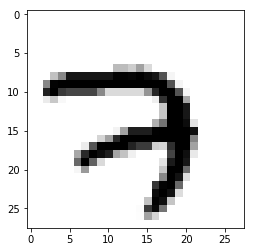

In [6]:
plt.imshow(img, cmap='Greys')

## Convolution with a gaussian kernel

Let's define a gaussian kernel and let's convolve the image with it.

In [7]:
ksize = 7

I'll start by defining a 1 dimensional gaussian

In [8]:
x = tf.linspace(-1.0, 1.0, ksize)

In [9]:
# The 1 dimensional gaussian takes two parameters,
# the mean value, and the standard deviation
mean = 0.0
std = 0.5
gaussian = (tf.exp(tf.negative(tf.pow(x - mean, 2.0) /
                          (2.0 * tf.pow(std, 2.0)))) *
            (1.0 / (std * tf.sqrt(2.0 * 3.1415))))

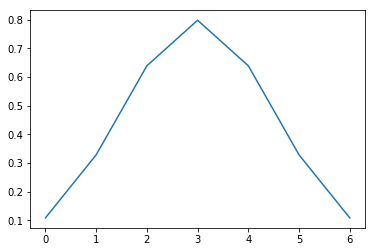

In [10]:
with tf.Session() as sess:
    res = gaussian.eval()
plt.plot(res)

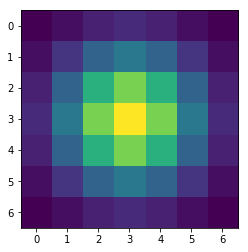

In [11]:
# Let's store the number of values in our Gaussian curve.
ksize = gaussian.get_shape().as_list()[0]

# Let's multiply the two to get a 2d gaussian
gaussian_2d = tf.matmul(tf.reshape(gaussian, [ksize, 1]), tf.reshape(gaussian, [1, ksize]))

# Execute the graph
with tf.Session() as sess:
    gaussian_2d_res = gaussian_2d.eval()

plt.imshow(gaussian_2d_res)

In [12]:
gaussian_2d_res

array([[ 0.01166044,  0.0354213 ,  0.06899127,  0.08615965,  0.06899126,
         0.03542129,  0.01166044],
       [ 0.0354213 ,  0.10760041,  0.20957698,  0.26172996,  0.20957695,
         0.10760038,  0.0354213 ],
       [ 0.06899127,  0.20957698,  0.4082002 ,  0.50978035,  0.40820014,
         0.20957692,  0.06899127],
       [ 0.08615965,  0.26172996,  0.50978035,  0.63663852,  0.50978029,
         0.2617299 ,  0.08615965],
       [ 0.06899126,  0.20957695,  0.40820014,  0.50978029,  0.40820011,
         0.20957689,  0.06899126],
       [ 0.03542129,  0.10760038,  0.20957692,  0.2617299 ,  0.20957689,
         0.10760035,  0.03542129],
       [ 0.01166044,  0.0354213 ,  0.06899127,  0.08615965,  0.06899126,
         0.03542129,  0.01166044]], dtype=float32)

Ok, now that we have a 2d Gaussian, we'd like to convolve it with the image. Remember that in order to do that we need to reshape both the image and the kernel as 4D tensors.

In [13]:
img_4d = tf.reshape(img, [1, img.shape[0], img.shape[1], 1])
print(img_4d)

Tensor("Reshape_2:0", shape=(1, 28, 28, 1), dtype=float32)


In [14]:
print(img_4d.get_shape())

(1, 28, 28, 1)


In [15]:
z_4d = tf.reshape(gaussian_2d, [ksize, ksize, 1, 1])
print(z_4d.get_shape())

(7, 7, 1, 1)


The convolution operation is performed in tensorflow using the `nn.conv2d` function

In [16]:
convolved = tf.nn.conv2d(img_4d, z_4d, strides=[1, 1, 1, 1], padding='SAME')
convolved

<tf.Tensor 'Conv2D:0' shape=(1, 28, 28, 1) dtype=float32>

In [17]:
with tf.Session() as sess:
    res = convolved.eval()
print(res.shape)

(1, 28, 28, 1)


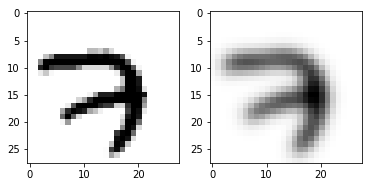

In [18]:
plt.subplot(121)
plt.imshow(img, cmap='Greys')

plt.subplot(122)
plt.imshow(np.squeeze(res), cmap='Greys')

# Or we could specify the exact dimensions we want to visualize:
# plt.imshow(res[0, :, :, 0], cmap='Greys')

## Exercise 1

1. define an arbitrary square filter (could be random or could be of your choice)
- convolve it with the image as displayed above
- display the image, the filter and the convolved image

(7, 7, 1, 1)
(1, 28, 28, 1)


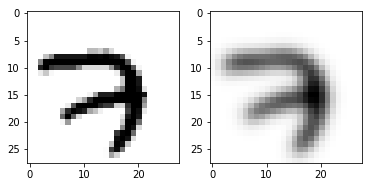

In [19]:
z_4d = tf.reshape(gaussian_2d, [ksize, ksize, 1, 1])
print(z_4d.get_shape())

convolved = tf.nn.conv2d(img_4d, z_4d, strides=[1, 1, 1, 1], padding='SAME')

with tf.Session() as sess:
    res = convolved.eval()
print(res.shape)

plt.subplot(121)
plt.imshow(img, cmap='Greys')

plt.subplot(122)
plt.imshow(np.squeeze(res), cmap='Greys')

## A simple convolutional model

In [20]:
tf.reset_default_graph()

In [21]:
# Parameters
learning_rate = 0.001
training_iters = 200000
batch_size = 128
display_step = 10

# Network Parameters
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.75 # Dropout, probability to keep units

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

## Exercise 2

create some wrappers for simplicity

1. create a function `conv2d(x, W, b, strides=1)` that creates a convolutional layer using the `tf.nn.conv2d` and `tf.nn.bias_add`.
- create a function `maxpool2d(x, k=2)` that performs max pooling using the `tf.nn.max_pool` function, where k is the stride in both directions.


In [27]:
def conv2d(x, W, b, strides=1):
    # your code here
    x = tf.nn.conv2d(x, W  , strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return x


def maxpool2d(x, k=2):
    # your code here
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

Create the model

In [28]:
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    with tf.name_scope('conv_net'):
        # Convolution Layer
        conv1 = conv2d(x, weights['wc1'], biases['bc1'])
        # Max Pooling (down-sampling)
        conv1 = maxpool2d(conv1, k=2)

        # Convolution Layer
        conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
        # Max Pooling (down-sampling)
        conv2 = maxpool2d(conv2, k=2)

        # Fully connected layer
        # Reshape conv2 output to fit fully connected layer input
        fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
        fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
        fc1 = tf.nn.relu(fc1)
        # Apply Dropout
        fc1 = tf.nn.dropout(fc1, dropout)

        # Output, class prediction
        out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

Store layers weight & biases

In [29]:
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32]), name='wc1'),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64]), name='wc2'),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024]), name='wd1'),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]), name='wout')
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32]), name='bc1'),
    'bc2': tf.Variable(tf.random_normal([64]), name='bc2'),
    'bd1': tf.Variable(tf.random_normal([1024]), name='bd1'),
    'out': tf.Variable(tf.random_normal([n_classes]), name='bout')
}

Construct model, define loss, optimizer, evaluation, initializer etc..

In [30]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

### Launch the graph

In [31]:
with tf.Session() as sess:
    sess.run(init)
    step = 1
    # Keep training until reach max iterations
    while step * batch_size < training_iters:
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step*batch_size) + ", Minibatch Loss= " + \
                  "{:.6f}".format(loss) + ", Training Accuracy= " + \
                  "{:.5f}".format(acc))
        step += 1
    print("Optimization Finished!")

    # Calculate accuracy for 256 mnist test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                      y: mnist.test.labels[:256],
                                      keep_prob: 1.}))

Iter 1280, Minibatch Loss= 22316.126953, Training Accuracy= 0.46875
Iter 2560, Minibatch Loss= 10033.872070, Training Accuracy= 0.67969
Iter 3840, Minibatch Loss= 10072.160156, Training Accuracy= 0.67188
Iter 5120, Minibatch Loss= 5490.777832, Training Accuracy= 0.80469
Iter 6400, Minibatch Loss= 3274.293945, Training Accuracy= 0.82031
Iter 7680, Minibatch Loss= 10087.425781, Training Accuracy= 0.75781
Iter 8960, Minibatch Loss= 4152.286621, Training Accuracy= 0.82812
Iter 10240, Minibatch Loss= 3178.867676, Training Accuracy= 0.82812
Iter 11520, Minibatch Loss= 1445.160889, Training Accuracy= 0.93750
Iter 12800, Minibatch Loss= 3591.924805, Training Accuracy= 0.79688
Iter 14080, Minibatch Loss= 1624.155029, Training Accuracy= 0.85938
Iter 15360, Minibatch Loss= 2047.910889, Training Accuracy= 0.92188
Iter 16640, Minibatch Loss= 4305.909180, Training Accuracy= 0.85938
Iter 17920, Minibatch Loss= 1686.503174, Training Accuracy= 0.92188
Iter 19200, Minibatch Loss= 2719.999512, Training A